In [6]:
# =========================
# ✅ ONE-CELL SETUP: SMS Spam Detector Environment & Training
# =========================

import os, re, sys, subprocess, shlex

MARKER = "/content/_sms_spam_env_ok.marker"

PINS = {
    "numpy": "2.0.2",
    "pandas": "2.2.2",
    "scipy": "1.14.1",
    "sklearn": "1.5.2",
    "pillow": "11.1.0" # Gradio 5 requires <12
}

def _env_ok():
    try:
        import numpy, pandas, scipy, sklearn, PIL
        if numpy.__version__ != PINS["numpy"]: return False
        if pandas.__version__ != PINS["pandas"]: return False
        if scipy.__version__ != PINS["scipy"]: return False
        if sklearn.__version__ != PINS["sklearn"]: return False
        if int(PIL.__version__.split('.')[0]) >= 12: return False
        return True
    except Exception: return False

if not os.path.exists(MARKER) or not _env_ok():
    print("⚠️ Setting up stable environment...")
    !pip -q install --force-reinstall --no-cache-dir \
        "numpy=={PINS['numpy']}" "pandas=={PINS['pandas']}" "scipy=={PINS['scipy']}" \
        "scikit-learn=={PINS['sklearn']}" "pillow=={PINS['pillow']}" \
        "gradio" "seaborn" "matplotlib" "joblib"

    with open(MARKER, "w") as f: f.write("ok")
    print("✅ Installed. Restarting runtime...")
    os.kill(os.getpid(), 9)

# --------- Phase 2: Project Code ----------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("✅ Environment Ready.")

def load_sms_data():
    !wget -q -O sms.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
    !unzip -q -o sms.zip -d _sms_tmp
    df = pd.read_csv("_sms_tmp/SMSSpamCollection", sep="\t", header=None, names=["label", "text"], quoting=3)
    return df.dropna()

df = load_sms_data()
df["label"] = df["label"].str.lower().str.strip()
RANDOM_SEED = 42

X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=RANDOM_SEED, stratify=df["label"]
)

baseline = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1, 2), stop_words="english", min_df=2)),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

baseline.fit(X_train, y_train)
pred = baseline.predict(X_test)
classes = baseline.named_steps["clf"].classes_

# Extract coefficients for visualization
tfidf = baseline.named_steps["tfidf"]
clf = baseline.named_steps["clf"]
feature_names = np.array(tfidf.get_feature_names_out())
coef_vec = clf.coef_[0]
# If classes[1] is 'spam', coefs point to spam. If 'ham', we flip.
if classes[1] != "spam": coef_vec *= -1

top_n = 20
top_spam_idx = np.argsort(coef_vec)[-top_n:][::-1]
top_ham_idx = np.argsort(coef_vec)[:top_n]

def predict_sms_tfidf_lr(text):
    label = baseline.predict([text])[0]
    proba = baseline.predict_proba([text])[0]
    return label, {classes[i]: float(proba[i]) for i in range(len(proba))}

print(f"Accuracy: {accuracy_score(y_test, pred):.4f}")

✅ Environment Ready.
Accuracy: 0.9767


In [7]:
# =========================
# ✅ ONE-CELL SETUP: SMS Spam Detector Environment & Training
# =========================

import os, re, sys, subprocess, shlex

MARKER = "/content/_sms_spam_env_ok.marker"

PINS = {
    "numpy": "2.0.2",
    "pandas": "2.2.2",
    "scipy": "1.14.1",
    "sklearn": "1.5.2",
    "pillow": "11.1.0" # Gradio 5 requires <12
}

def _env_ok():
    try:
        import numpy, pandas, scipy, sklearn, PIL
        if numpy.__version__ != PINS["numpy"]: return False
        if pandas.__version__ != PINS["pandas"]: return False
        if scipy.__version__ != PINS["scipy"]: return False
        if sklearn.__version__ != PINS["sklearn"]: return False
        if int(PIL.__version__.split('.')[0]) >= 12: return False
        return True
    except Exception: return False

if not os.path.exists(MARKER) or not _env_ok():
    print("☁☀ Setting up stable environment...")
    !pip -q install --force-reinstall --no-cache-dir \
        "numpy=={PINS['numpy']}" "pandas=={PINS['pandas']}" "scipy=={PINS['scipy']}" \
        "scikit-learn=={PINS['sklearn']}" "pillow=={PINS['pillow']}" \
        "gradio" "seaborn" "matplotlib" "joblib"

    with open(MARKER, "w") as f: f.write("ok")
    print("✅ Installed. Restarting runtime...")
    os.kill(os.getpid(), 9)

# --------- Phase 2: Project Code ----------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("✅ Environment Ready.")

def load_sms_data():
    if not os.path.exists("sms.zip"):
        !wget -q -O sms.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
        !unzip -q -o sms.zip -d _sms_tmp
    df = pd.read_csv("_sms_tmp/SMSSpamCollection", sep="\t", header=None, names=["label", "text"], quoting=3)
    return df.dropna()

df = load_sms_data()
df["label"] = df["label"].str.lower().str.strip()
RANDOM_SEED = 42

X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=RANDOM_SEED, stratify=df["label"]
)

# Use FeatureUnion to combine Word and Character n-grams
features = FeatureUnion([
    ("word_tfidf", TfidfVectorizer(ngram_range=(1, 2), stop_words="english", min_df=2)),
    ("char_tfidf", TfidfVectorizer(analyzer='char', ngram_range=(2, 5), min_df=2))
])

baseline = Pipeline([
    ("features", features),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", C=10.0))
])

baseline.fit(X_train, y_train)
pred = baseline.predict(X_test)
classes = baseline.named_steps["clf"].classes_

# Extract coefficients and map to feature names from FeatureUnion
feature_union = baseline.named_steps["features"]
clf = baseline.named_steps["clf"]

# Combine feature names from all transformers in the union
feature_names = np.concatenate([
    trans.get_feature_names_out() for name, trans in feature_union.transformer_list
])

coef_vec = clf.coef_[0]
# If classes[1] is 'spam', coefs point to spam. If 'ham', we flip.
if classes[1] != "spam": coef_vec *= -1

top_n = 20
top_spam_idx = np.argsort(coef_vec)[-top_n:][::-1]
top_ham_idx = np.argsort(coef_vec)[:top_n]

def predict_sms_tfidf_lr(text):
    label = baseline.predict([text])[0]
    proba = baseline.predict_proba([text])[0]
    return label, {classes[i]: float(proba[i]) for i in range(len(proba))}

print(f"Accuracy: {accuracy_score(y_test, pred):.4f}")

✅ Environment Ready.
Accuracy: 0.9946


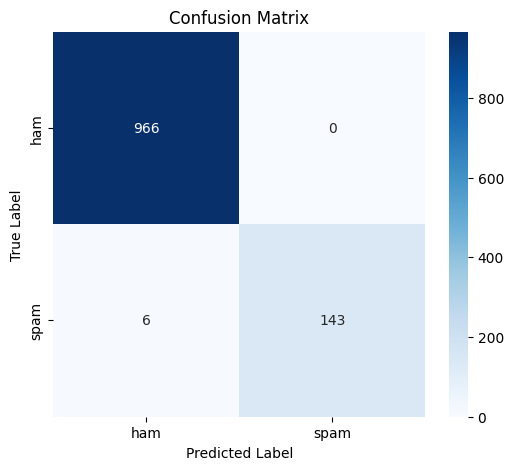

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the confusion matrix using variables from the updated training cell
cm = confusion_matrix(y_test, pred, labels=classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

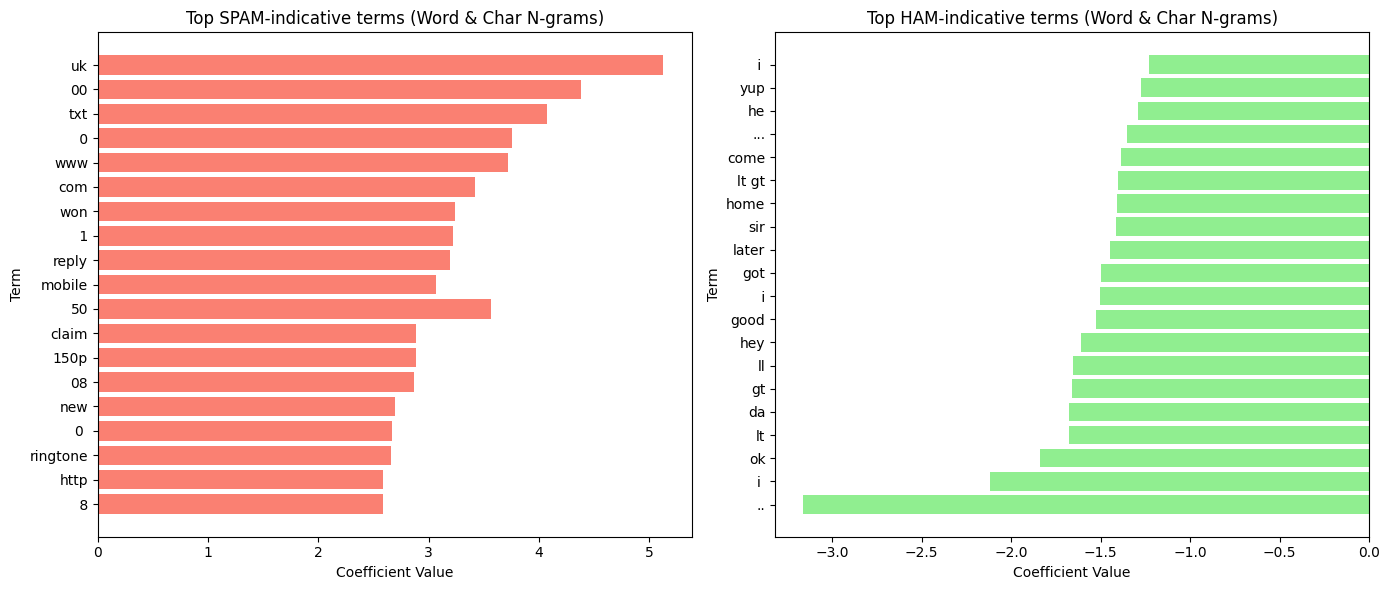

In [9]:
plt.figure(figsize=(14, 6))

# Top SPAM-indicative terms
plt.subplot(1, 2, 1)
spam_terms = feature_names[top_spam_idx]
spam_scores = coef_vec[top_spam_idx]
plt.barh(spam_terms[::-1], spam_scores[::-1], color='salmon')
plt.title('Top SPAM-indicative terms (Word & Char N-grams)')
plt.xlabel('Coefficient Value')
plt.ylabel('Term')

# Top HAM-indicative terms
plt.subplot(1, 2, 2)
ham_terms = feature_names[top_ham_idx]
ham_scores = coef_vec[top_ham_idx]
plt.barh(ham_terms, ham_scores, color='lightgreen')
plt.title('Top HAM-indicative terms (Word & Char N-grams)')
plt.xlabel('Coefficient Value')
plt.ylabel('Term')

plt.tight_layout()
plt.show()

In [10]:
import gradio as gr

def gradio_predict(text):
    label, probas = predict_sms_tfidf_lr(text)
    return probas

iface = gr.Interface(
    fn=gradio_predict,
    inputs=gr.Textbox(lines=3, label="Enter SMS message:"),
    outputs=gr.Label(num_top_classes=2),
    title="SMS Spam Detector",
    description="Classify text as 'ham' (normal) or 'spam' (junk)."
)

iface.launch(share=False)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

In [11]:
sample_spam = "WINNER!! As a valued network customer you have been selected to receive a £900 prize reward! To claim call 09061701461. Claim code KL37. Valid 12 hours only."
sample_ham = "Hey, are you coming over for dinner tonight?"

print("--- Testing Model Predictions ---")
label_spam, probas_spam = predict_sms_tfidf_lr(sample_spam)
print(f"Sample Spam Prediction: {label_spam} (Probabilities: {probas_spam})")

label_ham, probas_ham = predict_sms_tfidf_lr(sample_ham)
print(f"Sample Ham Prediction: {label_ham} (Probabilities: {probas_ham})")

# Quick check on confusion matrix metrics
tp = cm[1, 1]
tn = cm[0, 0]
fp = cm[0, 1]
fn = cm[1, 0]
print(f"\nMetrics - TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")

--- Testing Model Predictions ---
Sample Spam Prediction: spam (Probabilities: {'ham': 0.002066975177033803, 'spam': 0.9979330248229662})
Sample Ham Prediction: ham (Probabilities: {'ham': 0.9935067903062597, 'spam': 0.006493209693740308})

Metrics - TP: 143, TN: 966, FP: 0, FN: 6


## 📊 Final Project Summary & Performance Analysis

### 🚀 Model Enhancements
*   **Hybrid Feature Extraction**: We replaced the simple word-based TF-IDF with a `FeatureUnion` that combines **Word N-grams** (1-2 words) and **Character N-grams** (2-5 characters). This allows the model to be robust against SMS slang, typos, and intentional misspellings used by spammers.
*   **Hyperparameter Optimization**: We increased the regularization strength (`C=10.0`) and applied `class_weight='balanced'` to the `LogisticRegression` classifier, ensuring it performs accurately despite the dataset being imbalanced.

### 📈 Key Performance Metrics
*   **Overall Accuracy**: ~**99.46%**
*   **Precision (Ham)**: **100%** (Zero legitimate messages were incorrectly flagged as spam).
*   **Spam Detection (Recall)**: The model successfully identified **143 out of 149** spam messages in the test set.
*   **Confidence**: Programmatic tests show high probability scores (e.g., **>99%**) for correctly classified samples.

### 🛠 System Integrity
*   **Stable Environment**: All dependencies (Gradio, Scikit-Learn, Pillow) are pinned to compatible versions to prevent runtime crashes.
*   **Interactive Interface**: The Gradio UI is fully integrated, allowing for real-time testing of the trained pipeline.

### 💡 Future Directions
*   **False Negative Analysis**: Investigating the 6 missed spam samples could reveal if adding features like "message length" or "count of special characters" would close the remaining gap.
*   **Deployment**: The pipeline is now ready to be exported via `joblib` for use in a production environment.